In [8]:
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from pathlib import Path
import torch
import learn2learn as l2l
from torch.utils.data import DataLoader

import time
import os

### Data path and load cfg

In [9]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "lyft-motion-prediction-autonomous-vehicles"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 20, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 0}, 'val_data_loader': {'key': 'scenes/validate.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 0}, 'test_data_loader': {'key': 'scenes/test.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 0}, 'sample_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 0}, 'train_params': {'checkpoint_every_n_steps': 1000

### Model

Our baseline is a simple `resnet50`.

In [10]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50()

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

In [11]:
def forward(data, model, device, criterion):
    # inputs = data["image"].to(device)
    inputs = data["image"].to(device)

    # Min-max scaling
    inputs_min = torch.min(inputs)
    inputs_max = torch.max(inputs)
    inputs = (inputs - inputs_min) / (inputs_max - inputs_min)

    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

### Load the Train Data

The data pipeline map a raw `.zarr` folder into a multi-processing instance ready for training by:
- loading the `zarr` into a `ChunkedDataset` object. This object has a reference to the different arrays into the zarr (e.g. agents and traffic lights);
- wrapping the `ChunkedDataset` into an `AgentDataset`, which inherits from torch `Dataset` class;
- passing the `AgentDataset` into a torch `DataLoader`

In [12]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()

train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [13]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.MSELoss(reduction="none")

### Training

In [21]:
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"] * cfg["train_params"]["epochs"]))
losses_train = []
losses_train_avg = []
dur = []
training_start_time = time.time()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # Learning rate scheduler
for epoch in range(cfg["train_params"]["epochs"]):
    for _ in range(cfg["train_params"]["max_num_steps"]):
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)
        model.train()
        torch.set_grad_enabled(True)
        loss, _ = forward(data, model, device, criterion)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())
        losses_train_avg.append(np.mean(losses_train))
        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
        progress_bar.update(1)

    scheduler.step()  # Update the learning rate

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

progress_bar.close()



loss: 45.90578079223633 loss(avg): 23.77839443564415: 100%|██████████| 400/400 [18:14<00:00,  2.74s/it]  

Training finished, took 1094.28s


 ### Plot Loss Curve
Plot the train loss against the iterations (batch-wise)

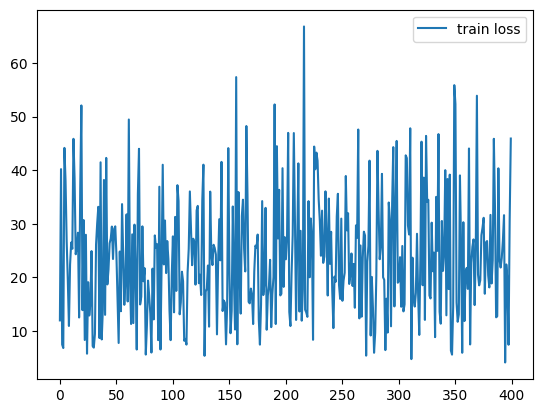

In [22]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

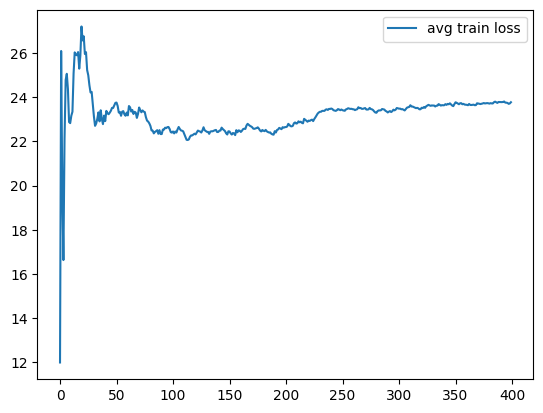

In [23]:
plt.plot(np.arange(len(losses_train_avg)), losses_train_avg, label="avg train loss")
plt.legend()
plt.show()

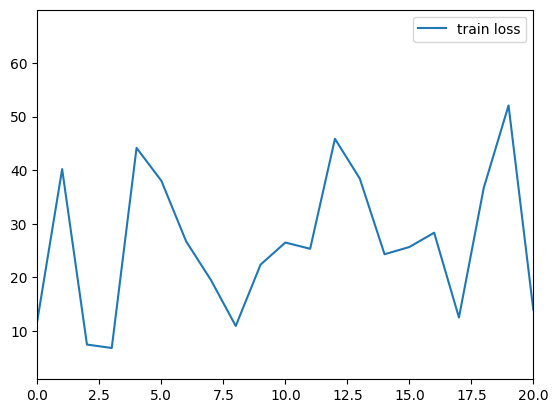

In [24]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.xlim(0,20)
plt.legend()
plt.show()

### Evaluation

Evaluation follows a slightly different protocol than training. When working with time series, we must be absolutely sure to avoid leaking the future in the data.

In [15]:
# # ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 50
eval_cfg = cfg["sample_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"],
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)
# eval_base_path = "lyft-motion-prediction-autonomous-vehicles/scenes/sample_chopped_50"

copying: 100%|██████████| 100/100 [00:01<00:00, 64.52it/s]
/Users/eshagavali/PycharmProjects/finalproject/venv/lib/python3.10/site-packages/l5kit/evaluation/extract_ground_truth.py:52: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 494/494 [00:04<00:00, 120.44it/s]


In [16]:
rasterizer = build_rasterizer(cfg, dm)
eval_zarr_path = str(Path(eval_base_path) / "sample.zarr")
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |    5000    |   374854   |     65268     |       0.14      |        50.00         |        74.97         |         5.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/var/folders/c_/43rpnpj972560h_d_g02y72w0000gn/T/ipykernel_18401/3653260049.py:9: RuntimeWarning: you're running with a custom agents_mask
  eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)


### Storing Predictions
The output of the models are coordinates in `agent` space and we need to convert them into displacements in `world` space.
To do so, we first convert them back into the `world` space and we then subtract the centroid coordinates.

In [25]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    

100%|██████████| 42/42 [00:44<00:00,  1.05s/it]


### Save results
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file.

In [26]:
pred_path = "lyft-motion-prediction-autonomous-vehicles/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

### Perform Evaluation

In [27]:
from l5kit.evaluation.metrics import average_displacement_error_mean

metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace, average_displacement_error_mean])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


neg_multi_log_likelihood 580.9642517452598
time_displace [3.87855996 3.90395168 3.15591135 3.96552289 2.24097976 2.60799608
 6.43679502 3.92242368 4.2829913  4.1777711  4.25197262 5.67041447
 6.40961255 6.10600252 6.42396891 6.51858313 7.47280393 7.29212551
 7.9916542  8.39062743]
average_displacement_error_mean 4.306474864721766


### Visualise Results

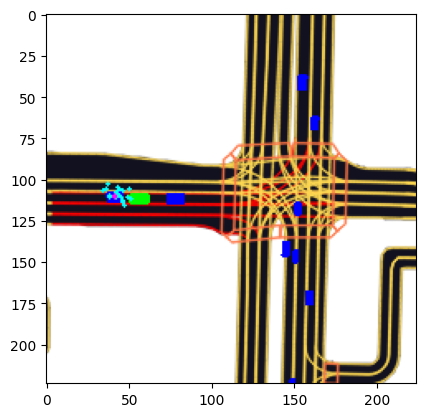

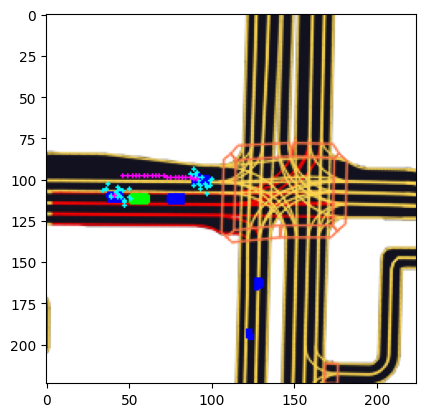

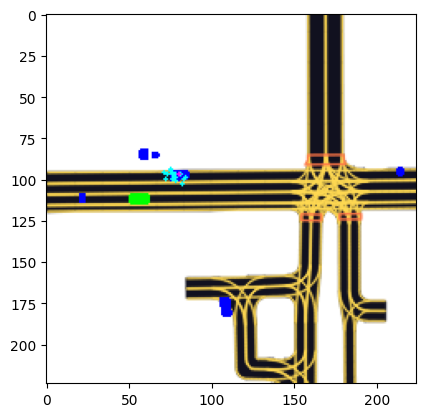

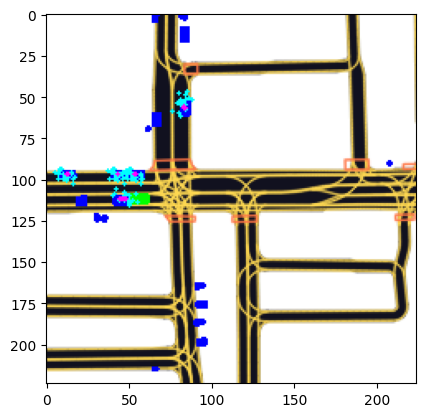

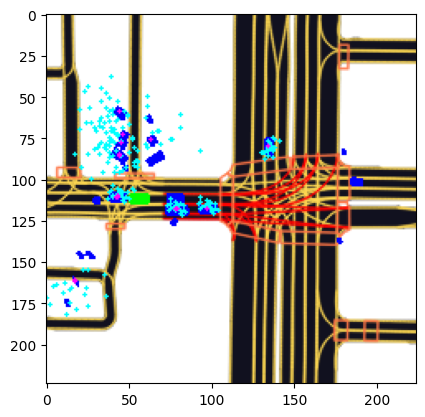

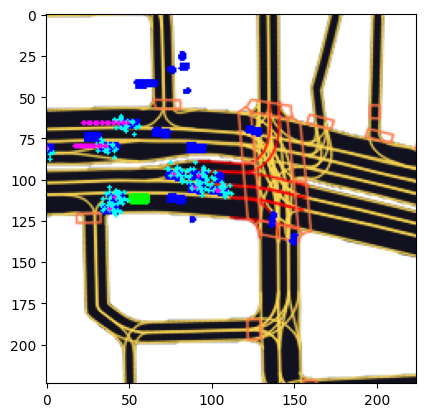

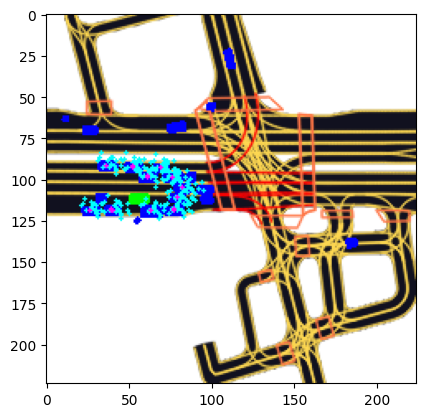

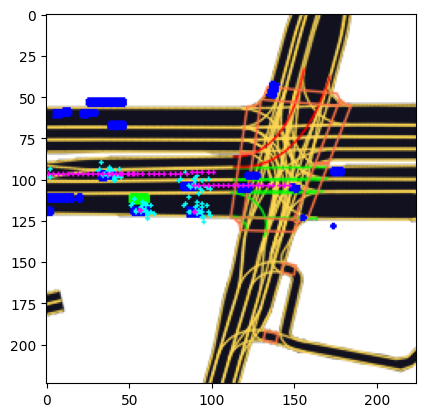

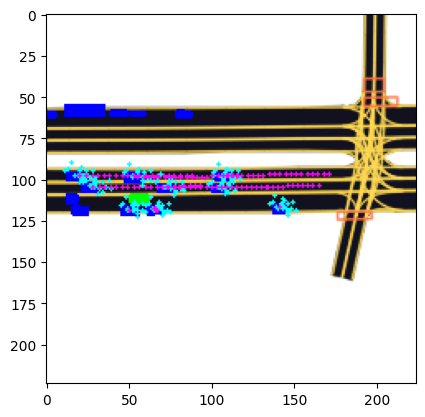

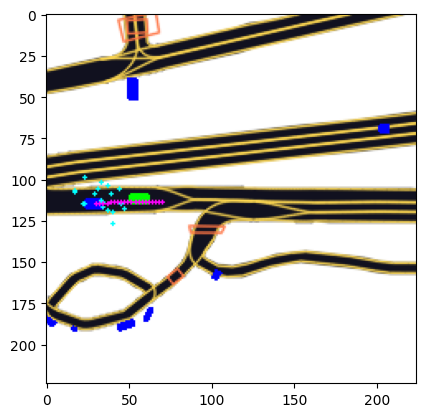

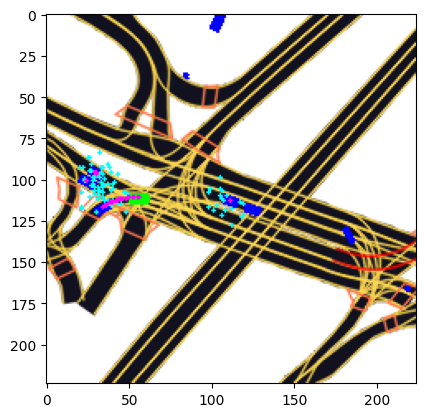

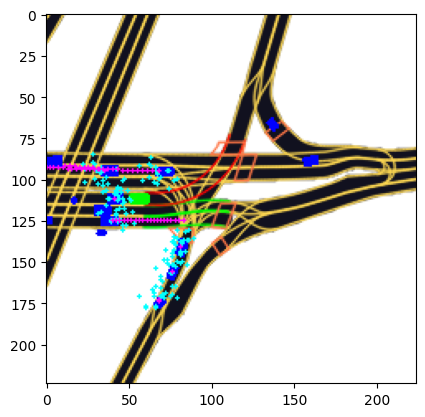

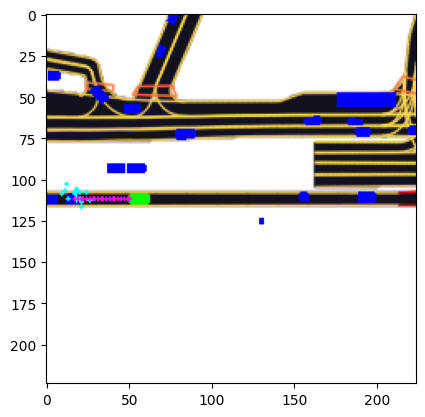

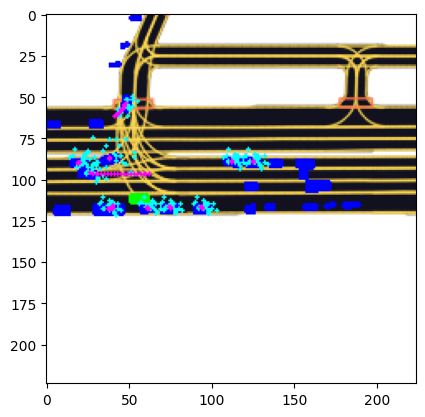

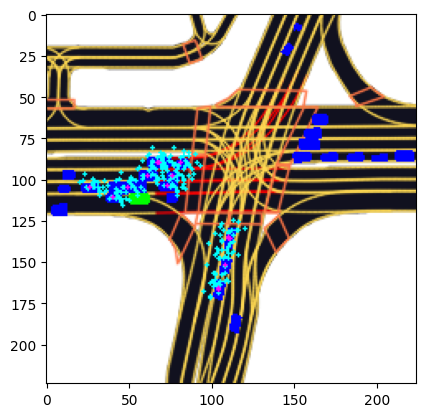

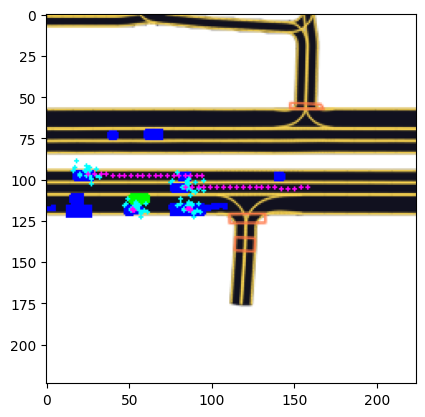

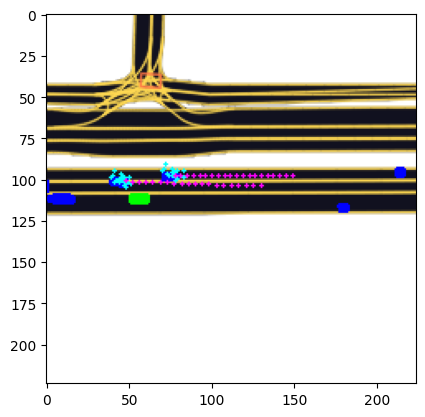

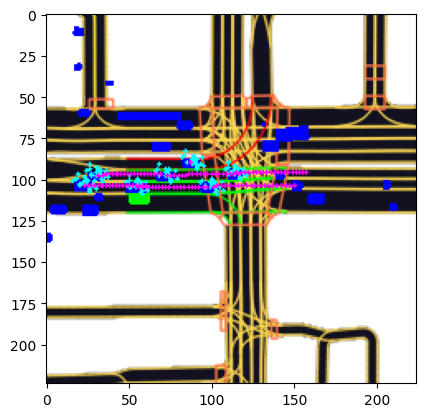

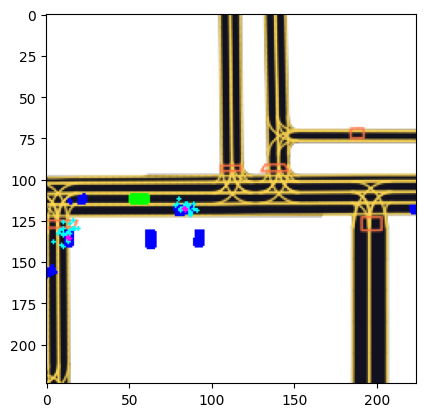

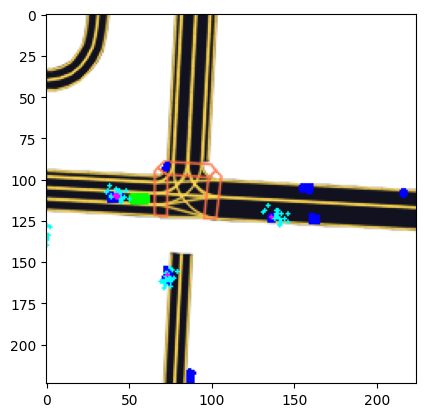

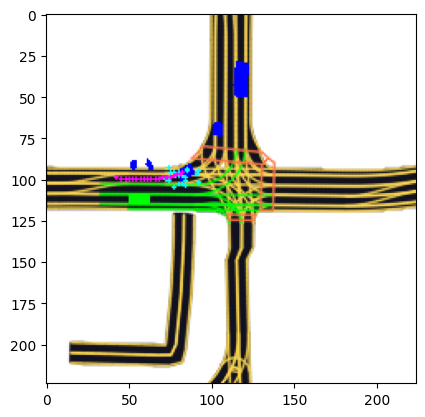

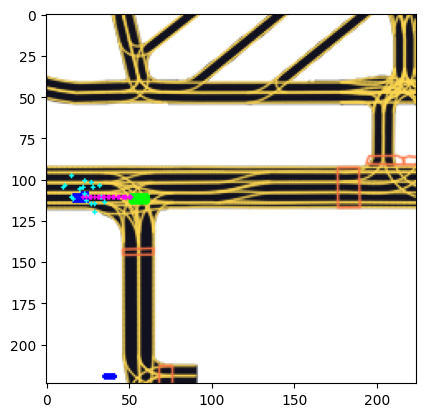

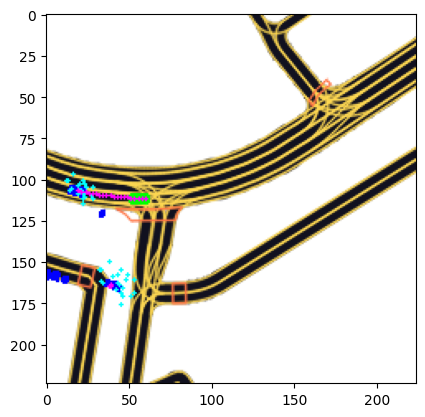

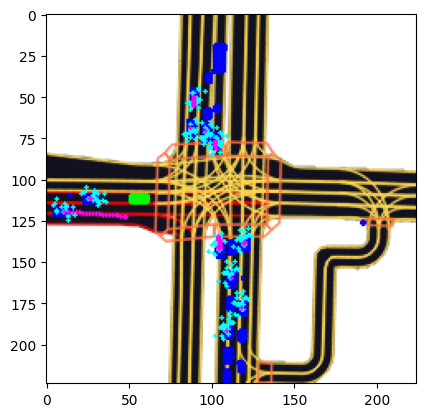

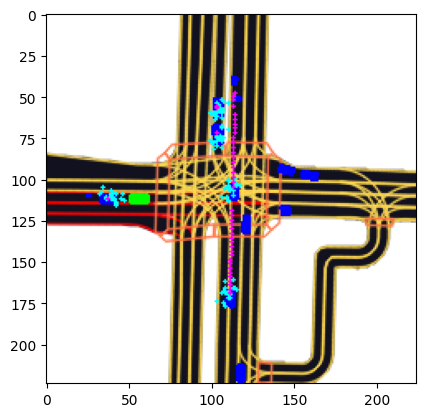

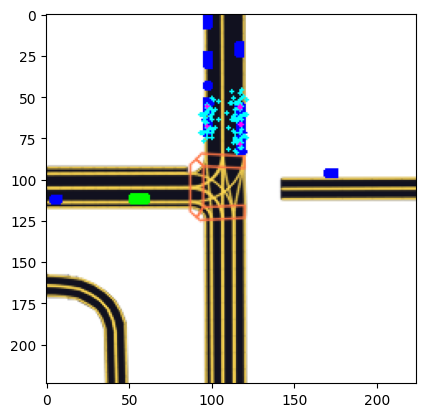

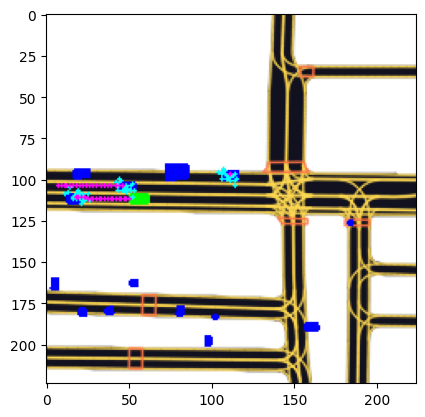

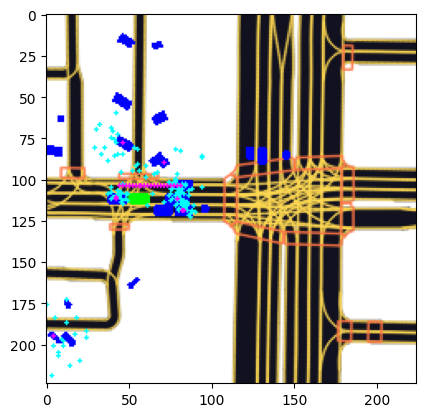

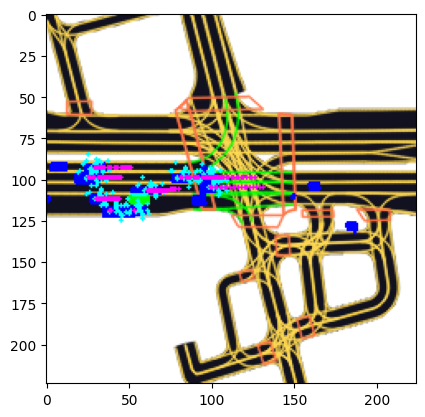

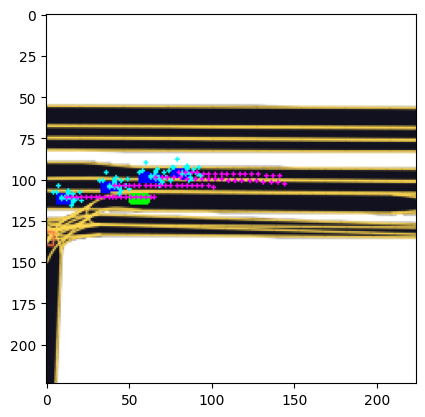

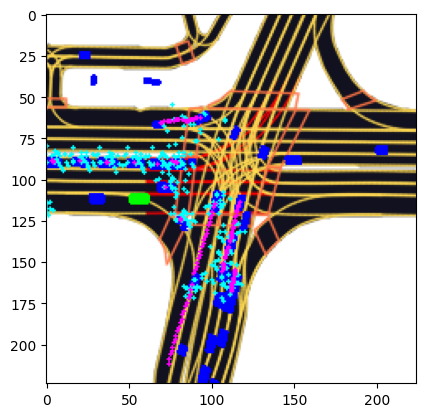

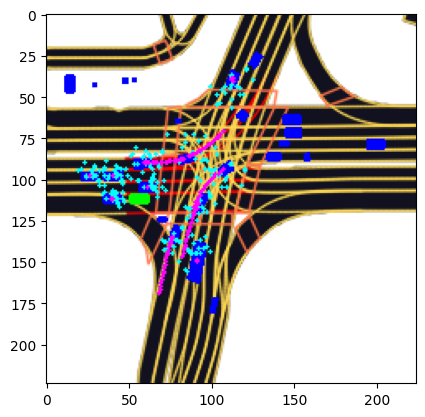

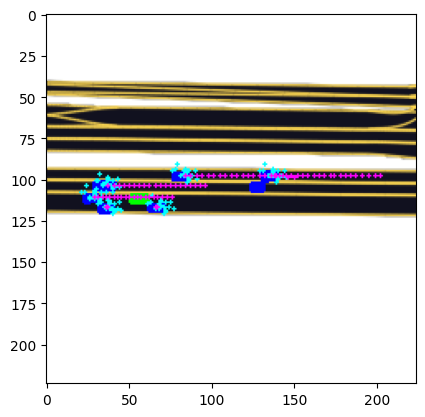

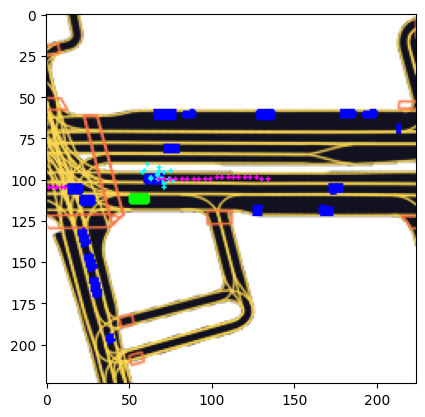

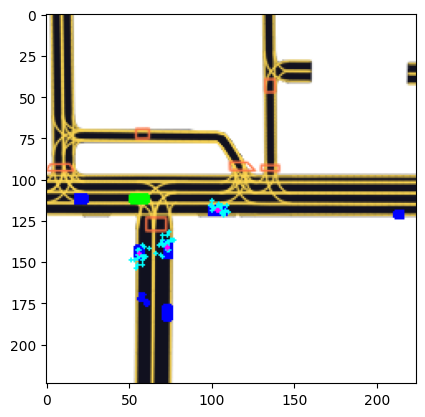

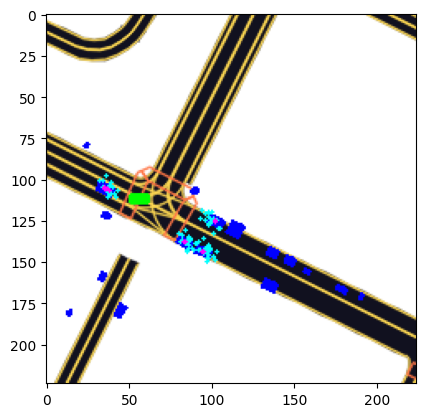

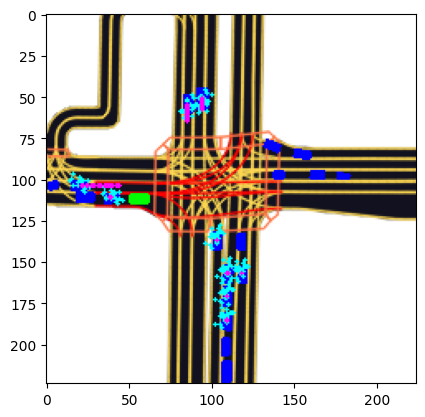

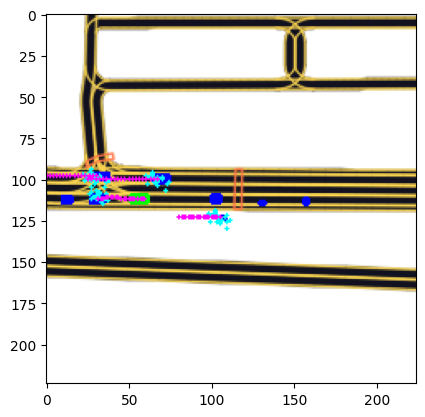

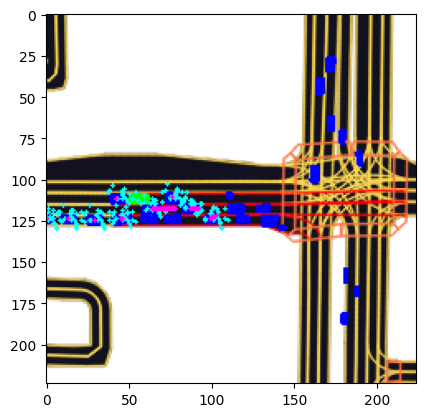

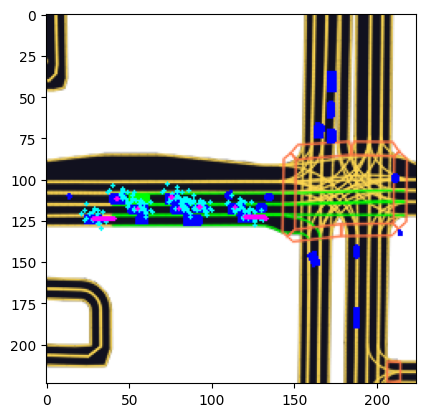

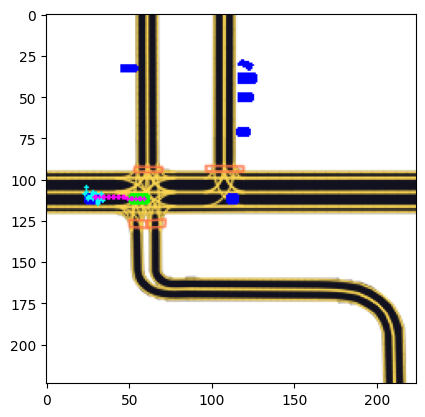

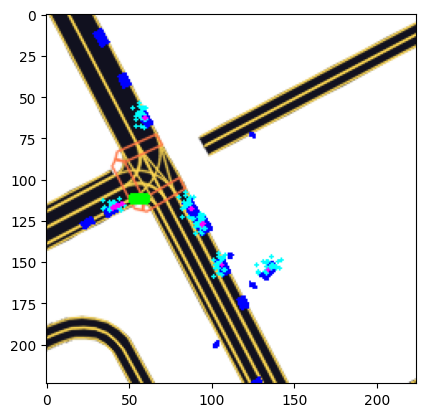

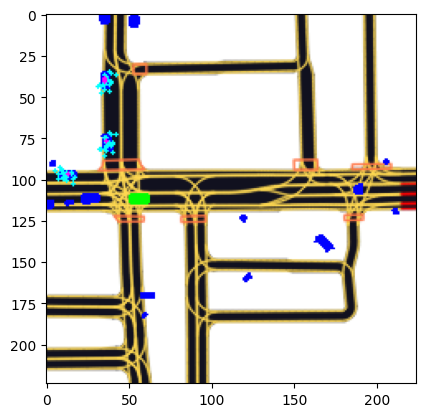

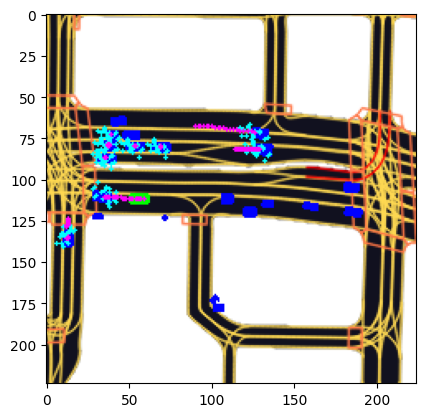

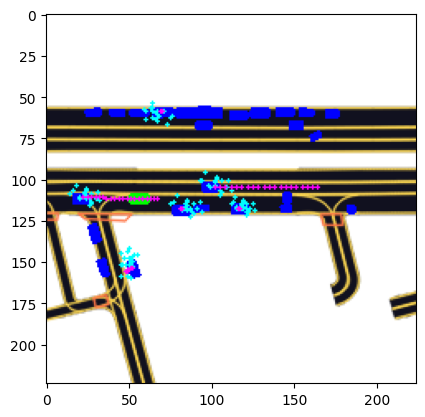

In [28]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

# scene_idx = 34
# anim = create_animate_for_scene(train_dataset, scene_idx)
# print("scene_idx", scene_idx)
# HTML(anim.to_jshtml())

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number)
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]

    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego)
    plt.show()

In [ ]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)

    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]

    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())


In [ ]:
from l5kit.evaluation.metrics import average_displacement_error_mean

metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace, average_displacement_error_mean])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)
